Apollo Snow Experiment Design
--

### Randomize by delta_ld
  - V1
    - Only MDE for delta LD
  - V2 
    - MDE both for delta LD and delta late

In [1]:
import lore.io
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings(action='ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.power import tt_ind_solve_power
from scipy import stats
import random

oak in development on jianhuitian@Jianhui-C02XD23FJGH5 with Python 3.7.3 & Lore 0.8.3


/Users/jianhuitian/.pyenv/versions/3.7.3/envs/oak/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
WEATHER_TYPE = 'snow'

# Read in climacell historical weather data

mypath = '/Users/jianhuitian/Documents/JianhuiTian/Work/Projects/Apollo/Snow/Instacart_processed'

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(join(mypath, onlyfiles[0]))

df = pd.DataFrame()

for file in onlyfiles:
    
    df_tmp = pd.read_csv(join(mypath, file))
    
    if len(df) == 0:
        df = df_tmp
    else:
        df = pd.concat([df, df_tmp])

df.head()

/Users/jianhuitian/Documents/JianhuiTian/Work/Projects/Apollo/Snow/Instacart_processed/processed_000000000018.csv


,zone_id,name,local_time,precip_rate,precip_type
0,1166,"Snow Hill, NC",2020-11-21 13:00:00,0.0,NaN
1,1166,"Snow Hill, NC",2020-11-21 14:00:00,0.0,NaN
2,1166,"Snow Hill, NC",2020-11-21 15:00:00,0.0,NaN
3,1166,"Snow Hill, NC",2020-11-21 16:00:00,0.0,NaN
4,1166,"Snow Hill, NC",2020-11-21 17:00:00,0.0,NaN


In [3]:
# Check Weather Data

df.isnull().sum()

zone_id               0
name                  0
local_time            0
precip_rate           0
precip_type    14808950
dtype: int64

In [4]:
df['precip_type'].unique().tolist()

[nan, 'rain', 'snow', 'ice_pellets', 'freezing_rain']

In [5]:
l0 = len(df[(df['precip_type'] == WEATHER_TYPE) & (df['precip_rate'] > 0.01)])
print('Precipation type snow hours: %d'%(l0))
print('Precipation type snow hour percent: %.3f'%(l0 / len(df)))

l1 = len(df[(df['precip_rate'].notnull()) & (df['precip_type'].isnull()) & 
   (df['precip_rate'] > 0)])
print('\nNo precipation type, but has NONE ZERO precipation: %d'%(l1))

l2 = len(df[(df['precip_rate'].notnull()) & (df['precip_type'].isnull()) & 
           (df['precip_rate'] == 0)])
print('\nNo precipation type, but has ZERO precipation number: %d'%(l2))
print('No precipation type, but has ZERO precipation number percentage: %.5f'%(l2 / len(df)))

Precipation type snow hours: 93456
Precipation type snow hour percent: 0.006

No precipation type, but has NONE ZERO precipation: 59

No precipation type, but has ZERO precipation number: 14808891
No precipation type, but has ZERO precipation number percentage: 0.94552


In [6]:
# Datatime transformation

df.loc[df['precip_type'].isnull(), ['precip_rate']] = None
df['local_time'] = pd.to_datetime(df['local_time'], infer_datetime_format=True)
df['date'] = df['local_time'].dt.date
df['quarter'] = df['local_time'].dt.quarter
df['dow'] = df['local_time'].dt.weekday
df['has_precip'] = (df['precip_type'] == WEATHER_TYPE) & (df['precip_rate'] >= 0.01)

df.fillna(value={'precip_rate':0}, inplace=True)
df_climacell_BAK = df.copy()

In [7]:
df.head()

,zone_id,name,local_time,precip_rate,precip_type,date,quarter,dow,has_precip
0,1166,"Snow Hill, NC",2020-11-21 13:00:00,0.0,NaN,2020-11-21,4,5,False
1,1166,"Snow Hill, NC",2020-11-21 14:00:00,0.0,NaN,2020-11-21,4,5,False
2,1166,"Snow Hill, NC",2020-11-21 15:00:00,0.0,NaN,2020-11-21,4,5,False
3,1166,"Snow Hill, NC",2020-11-21 16:00:00,0.0,NaN,2020-11-21,4,5,False
4,1166,"Snow Hill, NC",2020-11-21 17:00:00,0.0,NaN,2020-11-21,4,5,False


In [8]:
df_t1 = df[(df['precip_type'] == WEATHER_TYPE) 
           & (df['has_precip'] == True)][['zone_id', 'name', 
                                          'date', 'quarter', 'dow', 'precip_rate']].groupby(
                    ['zone_id', 'name', 'date', 'quarter', 'dow']).sum().reset_index()
df_t2 = df[(df['precip_type'] == WEATHER_TYPE) 
           & (df['has_precip'] == True)][['zone_id', 'name', 
                                          'date', 'quarter', 'dow', 'has_precip']].groupby(
                    ['zone_id', 'name', 'date', 'quarter', 'dow']).count().reset_index()
df_climacell = df_t1.merge(df_t2,
                          on=['zone_id', 'name', 'date', 'quarter', 'dow'])

print('Unique daily precipitation hours:')
print(sorted(df_climacell.has_precip.unique().tolist()))
print('\nDaily Max Precip: %.3f'%(df_climacell.precip_rate.max()))
print('Daily Min Precip: %.3f'%(df_climacell.precip_rate.min()))
df_climacell.head()

Unique daily precipitation hours:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

Daily Max Precip: 2.525
Daily Min Precip: 0.010


,zone_id,name,date,quarter,dow,precip_rate,has_precip
0,13,Boston,2020-10-30,4,4,0.321,6
1,13,Boston,2020-12-16,4,2,0.086,2
2,13,Boston,2020-12-17,4,3,1.377,17
3,13,Boston,2021-01-05,1,1,0.081,4
4,13,Boston,2021-01-21,1,3,0.027,2


In [9]:
df = lore.io.snowflake.dataframe("""
With zone_size as (
select delivery_completed_day_local::date as date,
region_id,
region_name,
zone_id,
zone_name,
launch_date, 
time_zone_name,
num_deliveries,
num_deliveries_r7d,
zone_maturity,
zone_size
from fact_zone_maturity_size_daily
where delivery_completed_day_local::date = convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 2
order by num_deliveries_r7d desc, zone_id, date
),

zone_supply_states as (
select zone_id, 
  avg(case when supply_balance_state = 'oversupplied' then 1 
       when supply_balance_state = 'balanced' then 0
       else -1 end) as supply_score
  from analysts.supply_states_zone
  where True
  and week_start >= date_trunc('week', convert_timezone('UTC', 'America/Los_Angeles', current_timestamp))::date - 14
  group by 1
  order by 1
),

deliveries as (
  SELECT
  od.id as delivery_id,
  od.zone_id,
  z.name,
  od.delivery_type,
  od.window_starts_at,
  od.window_ends_at,
  convert_timezone(z.time_zone_name, od.window_ends_at)::DATE as date, 
  case when od.delivery_type = 'pickup' then 1 else 0 end as is_pickup,
  case when od.delivery_type = 'pickup' then ps.delivery_started_at else od.delivered_at end as delivered_at,
  case when od.delivery_type = 'pickup' then od.window_starts_at else od.window_ends_at end as due_at
  FROM order_deliveries od
  INNER JOIN zones z ON od.zone_id = z.id
  INNER JOIN order_delivery_batches odb on odb.order_delivery_id = od.id and odb.canceled_at is null
  INNER JOIN picking_sets ps on ps.id = odb.batch_id
  WHERE od.workflow_state = 'delivered'
  AND ps.workflow_state = 'completed'
  AND convert_timezone(z.time_zone_name, od.window_ends_at)::DATE >= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 367
  AND convert_timezone(z.time_zone_name, od.window_ends_at)::DATE <= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 312
  ),

zone_lates as (
select date,
  zone_id,
  sum(case when delivered_at > due_at then 1 else 0 end) as late_orders,
  count(delivered_at) as tot_orders,
  round(avg(case when delivered_at > due_at then 1 else 0 end)*100, 1) as late_percent
from deliveries
where is_pickup = 0
group by 1, 2
order by 1, 2
),

zone_lost_demand as (
select dem.date, 
  dem.customer_zone_id as zone_id,
  sum(dem.total_lost_demand) as del_ld,
  sum(dem.deliveries_created) as del_created,
  round(sum(dem.total_demand), 1) as demand,
  case when sum(dem.total_demand) > 0 then round(sum(dem.total_lost_demand) / sum(dem.total_demand), 3) 
        else 1 end as ld_ratio
from demand_estimates_metrics dem
join zones z on z.id = dem.customer_zone_id
where date >= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 367
and date <= convert_timezone('UTC', 'America/Los_Angeles' , current_timestamp)::date - 312
and deleted_ind = 'N'
group by 1, 2
) 

select zld.date,
zld.zone_id,
zs.zone_name,
zs.region_id,
zs.region_name,
zld.ld_ratio,
zl.late_percent as late,
zss.supply_score,
zld.demand as daily_demand,
zs.num_deliveries_r7d as zone_del_r7d
from zone_lost_demand zld
join zone_lates zl on zld.date = zl.date and zld.zone_id = zl.zone_id
join zone_supply_states zss on zld.zone_id = zss.zone_id
join zone_size zs on zs.zone_id = zld.zone_id
""")

df['dt'] = df['date']
df['date'] = df['dt'].dt.date
df['quarter'] = df['dt'].dt.quarter
df['dow'] = df['dt'].dt.weekday

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [10]:
df.head()

,date,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,daily_demand,zone_del_r7d,dt,quarter,dow
0,2020-11-29,1291,"Heber City, UT",81,Salt Lake City,0.024,23.8,0.0,26.6,313,2020-11-29,4,6
1,2020-12-13,324,Grosse Point/St. Clair,28,Detroit,0.014,10.3,0.0,1056.7,8554,2020-12-13,4,6
2,2021-01-16,302,Winston-Salem,77,Piedmont Triad,0.046,22.9,0.0,688.5,6898,2021-01-16,1,5
3,2020-12-09,1192,"Carlsbad, NM",419,"Carlsbad, NM",0.004,10.0,1.0,32.1,154,2020-12-09,4,2
4,2021-01-10,583,"The Villages, FL",46,Orlando,0.041,22.9,1.0,509.8,3203,2021-01-10,1,6


In [11]:
df = df[['date', 'zone_id', 'zone_name', 'region_id', 'region_name',
        'ld_ratio', 'late', 'supply_score', 'daily_demand', 
         'zone_del_r7d', 'dow', 'quarter']].merge(
     df_climacell[['date', 'zone_id', 'precip_rate', 'has_precip']],
     on=['zone_id', 'date'],
     how='left')

In [12]:
df.head()

,date,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,daily_demand,zone_del_r7d,dow,quarter,precip_rate,has_precip
0,2020-11-29,1291,"Heber City, UT",81,Salt Lake City,0.024,23.8,0.0,26.6,313,6,4,NaN,NaN
1,2020-12-13,324,Grosse Point/St. Clair,28,Detroit,0.014,10.3,0.0,1056.7,8554,6,4,NaN,NaN
2,2021-01-16,302,Winston-Salem,77,Piedmont Triad,0.046,22.9,0.0,688.5,6898,5,1,NaN,NaN
3,2020-12-09,1192,"Carlsbad, NM",419,"Carlsbad, NM",0.004,10.0,1.0,32.1,154,2,4,NaN,NaN
4,2021-01-10,583,"The Villages, FL",46,Orlando,0.041,22.9,1.0,509.8,3203,6,1,NaN,NaN


### Can start from here, do not need to read in csv files and read from DB again. 

In [13]:
df_BAK = df.copy()
df.to_csv('zonal_day_info.csv', index=False)

In [14]:
if False:
    df = df_BAK.copy()  

Lost demand >= 0.2 counts:
766


(array([30498., 28691.,  7035.,  2865.,  1723.,  1273.,   702.,   481.,
          341.,   209.]),
 array([0.    , 0.0199, 0.0398, 0.0597, 0.0796, 0.0995, 0.1194, 0.1393,
        0.1592, 0.1791, 0.199 ]),
 <a list of 10 Patch objects>)

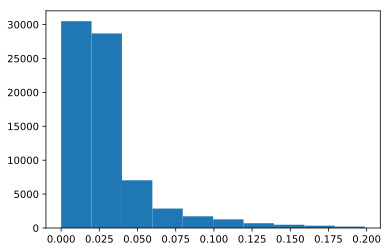

In [15]:
print('Lost demand >= 0.2 counts:')
print(len(df[df['ld_ratio'] >= 0.2]))
plt.hist(df[df['ld_ratio'] < 0.2]['ld_ratio'])

In [16]:
df['late'].quantile(0.5)

10.5

Late >= 50 counts:
1683


(array([12393., 22475., 16596.,  8476.,  5177.,  3355.,  2074.,  1120.,
          879.,   356.]),
 array([ 0.  ,  4.99,  9.98, 14.97, 19.96, 24.95, 29.94, 34.93, 39.92,
        44.91, 49.9 ]),
 <a list of 10 Patch objects>)

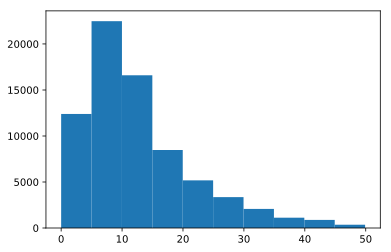

In [17]:
print('Late >= 50 counts:')
print(len(df[df['late'] >= 50]))
plt.hist(df[df['late'] < 50]['late'])

In [18]:
# Number of Zone/Day with Snow Precipitation

print(len(df[df['has_precip'].isnull()]))
print(len(df[df['has_precip'].notnull()]))
print('Total Zone/Day with Snow precipitation percent: %.3f'%
      (len(df[df['has_precip'].notnull()]) / len(df)))

68721
5863
Total Zone/Day with Snow precipitation percent: 0.079


In [19]:
# Check count to get snow days is right. 

df[['zone_id', 'has_precip']].groupby('zone_id').count().head()

,has_precip
zone_id,
1,0
13,4
14,11
16,2
18,3


In [20]:
df[(df['zone_id'] == 13) & df['has_precip'].notnull()]

,date,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,daily_demand,zone_del_r7d,dow,quarter,precip_rate,has_precip
3593,2021-01-21,13,Boston,3,Boston,0.060,7.3,-1.0,951.5,6481,3,1,0.027,2.0
4575,2021-01-05,13,Boston,3,Boston,0.159,18.9,-1.0,1136.3,6481,1,1,0.081,4.0
49504,2020-12-17,13,Boston,3,Boston,0.324,25.6,-1.0,739.2,6481,3,4,1.377,17.0
50111,2020-12-16,13,Boston,3,Boston,0.266,15.8,-1.0,1338.7,6481,2,4,0.086,2.0


In [22]:
print('Max date is : %s'%(df.date.max()))
print('Min date is : %s'%(df.date.min()))

Max date is : 2021-01-22
Min date is : 2020-11-28


In [23]:
# Get snow days
# Get DoW LD without snow

df_snow_days = df[['zone_id', 'has_precip']].groupby('zone_id').count()\
                    .reset_index().rename(columns={'has_precip': 'snow_days'})
df_ld_nosnow = df[df['has_precip'].isnull()][['zone_id', 'dow', 'ld_ratio', 'late']]\
                    .groupby(['zone_id', 'dow']).mean().reset_index()\
                    .rename(columns={'ld_ratio':'ld_ratio_nosnow',
                                     'late':'late_nosnow'})

# Get snow DeltaLD = ld_rain - ld_norain
if 'ld_ratio_nosnow' in df.columns.tolist():
    df.drop(columns=['ld_ratio_nosnow', 'late_nosnow'], inplace=True)
    
df = df.merge(df_ld_nosnow,
             on=['zone_id', 'dow'],
             how='left')
df['ld_delta'] = df['ld_ratio'] - df['ld_ratio_nosnow']
df['late_delta'] = df['late'] - df['late_nosnow']

# Only care LD delta and Late delta for snow days.
df.loc[df['has_precip'].isnull(), ['ld_delta']] = None
df.loc[df['has_precip'].isnull(), ['late_delta']] = None

In [24]:
# The master DF for all other analysis. 

df.notnull().sum()

date               74584
zone_id            74584
zone_name          74584
region_id          74584
region_name        74584
ld_ratio           74584
late               74584
supply_score       74584
daily_demand       74584
zone_del_r7d       74584
dow                74584
quarter            74584
precip_rate         5863
has_precip          5863
ld_ratio_nosnow    74581
late_nosnow        74581
ld_delta            5860
late_delta          5860
dtype: int64

## Beginning checking only zone/day with events, all zones

In [25]:
# Check Delta LD for Zone/Day having events

df_check = df[df['has_precip'].notnull()].copy()

df_check['delta_positive'] = df_check['ld_delta'].map(lambda x: 1 if x > 0 else 0)
df_check['delta_negative'] = df_check['ld_delta'].map(lambda x: 1 if x < 0 else 0)
df_check_count = df_check[['zone_id', 'delta_positive', 'delta_negative']]\
            .groupby('zone_id').sum().reset_index().rename(columns={'delta_positive':'positive_cnt',
                                                                    'delta_negative': 'negative_cnt'})
df_check = df_check.merge(df_check_count,
                               on=['zone_id'],
                               how='left')

In [26]:
positive_ld_zones = df_check_count[(df_check_count['positive_cnt'] > 0) & 
                       (df_check_count['negative_cnt'] == 0)].zone_id.unique().tolist()

print('Number of zones with only positive LD:')
print(len(df_check_count[(df_check_count['positive_cnt'] > 0) & 
                       (df_check_count['negative_cnt'] == 0)]))
print('Zones with only positive LD, total zone/days:')
print(df_check_count[(df_check_count['positive_cnt'] > 0) & 
                       (df_check_count['negative_cnt'] == 0)]['positive_cnt'].sum())

print('\nNumber of zones with only negative LD:')
print(len(df_check_count[(df_check_count['positive_cnt'] == 0) & 
                       (df_check_count['negative_cnt'] > 0)]))
print('Zones with only negative LD, total zone/days:')
print(df_check_count[(df_check_count['positive_cnt'] == 0) & 
                       (df_check_count['negative_cnt'] > 0)]['negative_cnt'].sum())

both_ld_zones = df_check_count[(df_check_count['positive_cnt'] > 0) & 
                      (df_check_count['negative_cnt'] > 0)].zone_id.unique().tolist()

print('\nNumber of zones with both positive and negative LD:')
print(len(df_check_count[(df_check_count['positive_cnt'] > 0) & 
                      (df_check_count['negative_cnt'] > 0)]))
print('Zones with both positive and negative LD, total positive zone/days:')
print(df_check_count[(df_check_count['positive_cnt'] > 0) & 
                      (df_check_count['negative_cnt'] > 0)]['positive_cnt'].sum())
print('Zones with both positive and negative LD, total negative zone/days:')
print(df_check_count[(df_check_count['positive_cnt'] > 0) & 
                      (df_check_count['negative_cnt'] > 0)]['negative_cnt'].sum())

Number of zones with only positive LD:
152
Zones with only positive LD, total zone/days:
339

Number of zones with only negative LD:
52
Zones with only negative LD, total zone/days:
92

Number of zones with both positive and negative LD:
644
Zones with both positive and negative LD, total positive zone/days:
2778
Zones with both positive and negative LD, total negative zone/days:
2640


In [27]:
# For Positive LD zones

print('LD Delta Mean:')
print(round(df_check[df_check['zone_id'].isin(positive_ld_zones)]['ld_delta'].mean(), 3))
print('\nLD Delta STD:')
print(round(df_check[df_check['zone_id'].isin(positive_ld_zones)]['ld_delta'].std(), 3))

LD Delta Mean:
0.062

LD Delta STD:
0.075


#### Analysis for Late Delta

In [28]:
# Check Delta Late for Zone/Day having events

df_check_late = df[df['has_precip'].notnull()].copy()

df_check_late['delta_positive'] = df_check_late['late_delta'].map(lambda x: 1 if x > 0 else 0)
df_check_late['delta_negative'] = df_check_late['late_delta'].map(lambda x: 1 if x < 0 else 0)
df_check_late_count = df_check_late[['zone_id', 'delta_positive', 'delta_negative']]\
            .groupby('zone_id').sum().reset_index().rename(columns={'delta_positive':'positive_cnt',
                                                                    'delta_negative': 'negative_cnt'})
df_check_late = df_check_late.merge(df_check_late_count,
                               on=['zone_id'],
                               how='left')

In [29]:
positive_late_zones = df_check_late_count[(df_check_late_count['positive_cnt'] > 0) & 
                       (df_check_late_count['negative_cnt'] == 0)].zone_id.unique().tolist()

print('Number of zones with only positive Late:')
print(len(df_check_late_count[(df_check_late_count['positive_cnt'] > 0) & 
                       (df_check_late_count['negative_cnt'] == 0)]))
print('Zones with only positive Late, total zone/days:')
print(df_check_late_count[(df_check_late_count['positive_cnt'] > 0) & 
                       (df_check_late_count['negative_cnt'] == 0)]['positive_cnt'].sum())

print('\nNumber of zones with only negative Late:')
print(len(df_check_late_count[(df_check_late_count['positive_cnt'] == 0) & 
                       (df_check_late_count['negative_cnt'] > 0)]))
print('Zones with only negative Late, total zone/days:')
print(df_check_late_count[(df_check_late_count['positive_cnt'] == 0) & 
                       (df_check_late_count['negative_cnt'] > 0)]['negative_cnt'].sum())

both_Late_zones = df_check_late_count[(df_check_late_count['positive_cnt'] > 0) & 
                      (df_check_late_count['negative_cnt'] > 0)].zone_id.unique().tolist()

print('\nNumber of zones with both positive and negative Late:')
print(len(df_check_late_count[(df_check_late_count['positive_cnt'] > 0) & 
                      (df_check_late_count['negative_cnt'] > 0)]))
print('Zones with both positive and negative Late, total positive zone/days:')
print(df_check_late_count[(df_check_late_count['positive_cnt'] > 0) & 
                      (df_check_late_count['negative_cnt'] > 0)]['positive_cnt'].sum())
print('Zones with both positive and negative Late, total negative zone/days:')
print(df_check_late_count[(df_check_late_count['positive_cnt'] > 0) & 
                      (df_check_late_count['negative_cnt'] > 0)]['negative_cnt'].sum())

Number of zones with only positive Late:
147
Zones with only positive Late, total zone/days:
326

Number of zones with only negative Late:
48
Zones with only negative Late, total zone/days:
84

Number of zones with both positive and negative Late:
653
Zones with both positive and negative Late, total positive zone/days:
2961
Zones with both positive and negative Late, total negative zone/days:
2468


In [30]:
# For Positive Late zones

print('Late Delta Mean:')
print(round(df_check_late[df_check_late['zone_id'].isin(positive_late_zones)]['late_delta'].mean(), 3))
print('\nLate Delta STD:')
print(round(df_check_late[df_check_late['zone_id'].isin(positive_late_zones)]['late_delta'].std(), 3))

Late Delta Mean:
12.065

Late Delta STD:
12.422


#### End Check Only Event Zone/Day

## Check Delta LD for all snow days with decent demand.

In [31]:
# LD Delta

df_ld_delta = df[(df['has_precip'].notnull()) & (df['daily_demand'] >= 20)] 

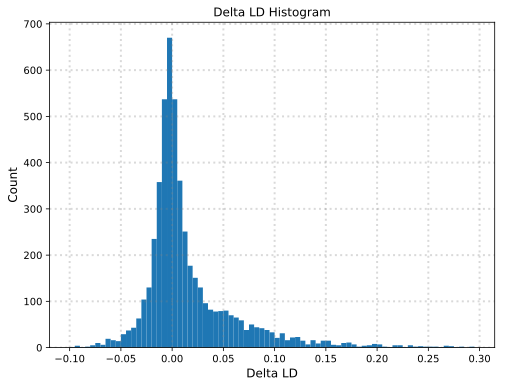

In [32]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.hist(df_ld_delta['ld_delta'],
        bins=[0.005 * i for i in range(-20, 60)])
ax1.set_xlabel('Delta LD',fontsize=12)
ax1.set_ylabel('Count',fontsize=12)
ax1.set_title('Delta LD Histogram')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.show()

In [33]:
# If Delta LD > 0.3, then reduce to 0.3 to reduce STD. 
df_ld_delta['ld_delta'] = df_ld_delta['ld_delta'].map(lambda x: 0.3 if x > 0.3 else 
                                                                -0.1 if x < -0.1 else x)
df_ld_delta['delta_positive'] = df_ld_delta['ld_delta'].map(lambda x: 1 if x > 0 else 0)
df_ld_delta['delta_negative'] = df_ld_delta['ld_delta'].map(lambda x: 1 if x < 0 else 0)
df_ld_change_count = df_ld_delta[['zone_id', 'delta_positive', 'delta_negative']]\
            .groupby('zone_id').sum().reset_index().rename(columns={'delta_positive':'positive_cnt',
                                                                    'delta_negative': 'negative_cnt'})
df_ld_delta = df_ld_delta.merge(df_ld_change_count,
                               on=['zone_id'],
                               how='left')

In [34]:
positive_ld_zones = df_ld_change_count[(df_ld_change_count['positive_cnt'] > 0) & 
                       (df_ld_change_count['negative_cnt'] == 0)].zone_id.unique().tolist()

print('Number of zones with only positive LD:')
print(len(positive_ld_zones))

print('\nZones with only positive LD, total zone/days:')
print(df_ld_change_count[(df_ld_change_count['positive_cnt'] > 0) & 
                       (df_ld_change_count['negative_cnt'] == 0)]['positive_cnt'].sum())

Number of zones with only positive LD:
154

Zones with only positive LD, total zone/days:
332


In [35]:
both_ld_zones = df_ld_change_count[(df_ld_change_count['positive_cnt'] > 0) & 
                       (df_ld_change_count['negative_cnt'] > 0)].zone_id.unique().tolist()


print('Number of zones with both positive and negative LD:')
print(len(both_ld_zones))
print('\nZones with both positive and negative LD, total positive zone/days:')
print(df_ld_change_count[(df_ld_change_count['positive_cnt'] > 0) & 
                       (df_ld_change_count['negative_cnt'] > 0)]['positive_cnt'].sum())
print('Zones with both positive and negative LD, total negative zone/days:')
print(df_ld_change_count[(df_ld_change_count['positive_cnt'] > 0) & 
                       (df_ld_change_count['negative_cnt'] > 0)]['negative_cnt'].sum())

Number of zones with both positive and negative LD:
564

Zones with both positive and negative LD, total positive zone/days:
2430
Zones with both positive and negative LD, total negative zone/days:
2216


In [36]:
len(df_ld_change_count[(df_ld_change_count['positive_cnt'] == 0) & 
                       (df_ld_change_count['negative_cnt'] > 0)])

39

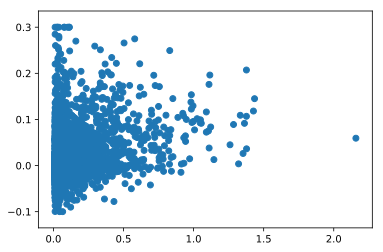

In [37]:
x = df_ld_delta[df_ld_delta['zone_id'].isin(both_ld_zones)]['precip_rate']
y = df_ld_delta[df_ld_delta['zone_id'].isin(both_ld_zones)]['ld_delta']
plt.scatter(x, y)

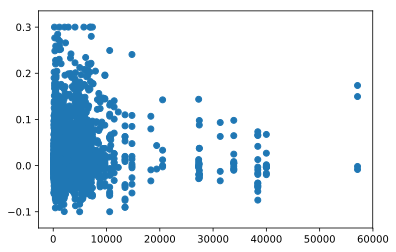

In [38]:
x = df_ld_delta[df_ld_delta['zone_id'].isin(both_ld_zones)]['zone_del_r7d']
y = df_ld_delta[df_ld_delta['zone_id'].isin(both_ld_zones)]['ld_delta']
plt.scatter(x, y)

(array([1702.,  299.,  105.,   48.,   33.,   13.,    6.,    4.,    4.,
           2.]),
 array([0.012 , 0.1018, 0.1916, 0.2814, 0.3712, 0.461 , 0.5508, 0.6406,
        0.7304, 0.8202, 0.91  ]),
 <a list of 10 Patch objects>)

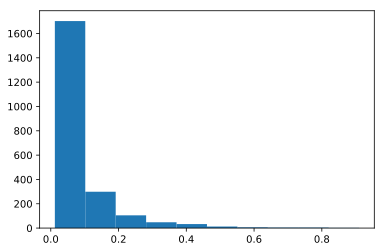

In [39]:
# Check daily_rain distribution of ld_delta < 0

plt.hist(df_ld_delta[(df_ld_delta['zone_id'].isin(both_ld_zones)) & 
            (df_ld_delta['ld_delta'] < 0)]['precip_rate'])

(array([1.957e+03, 2.890e+02, 1.010e+02, 4.200e+01, 2.100e+01, 1.000e+01,
        9.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.01  , 0.2248, 0.4396, 0.6544, 0.8692, 1.084 , 1.2988, 1.5136,
        1.7284, 1.9432, 2.158 ]),
 <a list of 10 Patch objects>)

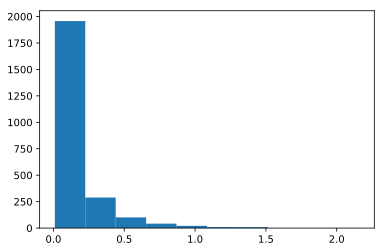

In [40]:
# Check daily_rain distribution of ld_delta > 0

plt.hist(df_ld_delta[(df_ld_delta['zone_id'].isin(both_ld_zones)) & 
            (df_ld_delta['ld_delta'] > 0)]['precip_rate'])

In [41]:
df.notnull().sum()

date               74584
zone_id            74584
zone_name          74584
region_id          74584
region_name        74584
ld_ratio           74584
late               74584
supply_score       74584
daily_demand       74584
zone_del_r7d       74584
dow                74584
quarter            74584
precip_rate         5863
has_precip          5863
ld_ratio_nosnow    74581
late_nosnow        74581
ld_delta            5860
late_delta          5860
dtype: int64

In [42]:
df_ld_delta.notnull().sum()

date               5056
zone_id            5056
zone_name          5056
region_id          5056
region_name        5056
ld_ratio           5056
late               5056
supply_score       5056
daily_demand       5056
zone_del_r7d       5056
dow                5056
quarter            5056
precip_rate        5056
has_precip         5056
ld_ratio_nosnow    5056
late_nosnow        5056
ld_delta           5056
late_delta         5056
delta_positive     5056
delta_negative     5056
positive_cnt       5056
negative_cnt       5056
dtype: int64

In [43]:
# For all zones and all snow days

print('LD Delta Mean:')
print(round(df_ld_delta['ld_delta'].mean(), 3))
print('\nLD Delta STD:')
print(round(df_ld_delta['ld_delta'].std(), 3))
print('\nNumber of snow_day/zone:')
print(len(df_ld_delta))

LD Delta Mean:
0.017

LD Delta STD:
0.048

Number of snow_day/zone:
5056


In [44]:
# For only Positive LD zones

print('LD Delta Mean:')
print(round(df_ld_delta[df_ld_delta['zone_id'].isin(positive_ld_zones)]['ld_delta'].mean(), 3))
print('\nLD Delta STD:')
print(round(df_ld_delta[df_ld_delta['zone_id'].isin(positive_ld_zones)]['ld_delta'].std(), 3))
print('\nNumber of snow_day/zone:')
print(len(df_ld_delta[df_ld_delta['zone_id'].isin(positive_ld_zones)]))

LD Delta Mean:
0.059

LD Delta STD:
0.064

Number of snow_day/zone:
332


In [45]:
# All Positive LD Snow_Day/Zone

print('LD Delta Mean:')
print(round(df_ld_delta[df_ld_delta['ld_delta'] > 0]['ld_delta'].mean(), 3))
print('\nLD Delta STD:')
print(round(df_ld_delta[df_ld_delta['ld_delta'] > 0]['ld_delta'].std(), 3))
print('\nNumber of positive delta_ld snow_day/zone:')
print(len(df_ld_delta[df_ld_delta['ld_delta'] > 0]))

LD Delta Mean:
0.042

LD Delta STD:
0.051

Number of positive delta_ld snow_day/zone:
2762


(array([151.,  53.,  51.,  30.,  15.,  12.,   3.,   8.,   3.,   6.]),
 array([3.46944695e-18, 3.00000000e-02, 6.00000000e-02, 9.00000000e-02,
        1.20000000e-01, 1.50000000e-01, 1.80000000e-01, 2.10000000e-01,
        2.40000000e-01, 2.70000000e-01, 3.00000000e-01]),
 <a list of 10 Patch objects>)

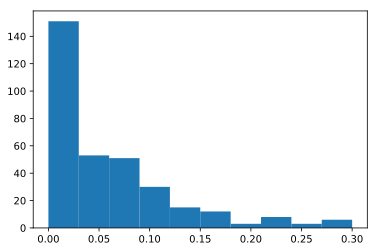

In [46]:
plt.hist(df_ld_delta[df_ld_delta['zone_id'].isin(positive_ld_zones)]['ld_delta'])

#### DF Late Delta Mean And STD for MDE analysis

In [47]:
# Late Delta

df_late_delta = df[(df['has_precip'].notnull()) & (df['daily_demand'] >= 20)] 

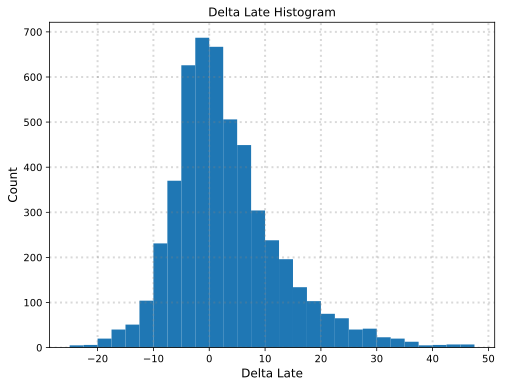

In [48]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.hist(df_late_delta['late_delta'],
        bins=[2.5 * i for i in range(-10, 20)])
ax1.set_xlabel('Delta Late',fontsize=12)
ax1.set_ylabel('Count',fontsize=12)
ax1.set_title('Delta Late Histogram')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.show()

In [49]:
# If Delta Late > 40.0, then reduce to 40.0 to reduce STD. 

df_late_delta['late_delta'] = df_late_delta['late_delta'].map(lambda x: 45.0 if x > 45.0 else
                                                                        -25.0 if x < -25.0 else x)
df_late_delta['delta_positive'] = df_late_delta['late_delta'].map(lambda x: 1 if x > 0 else 0)
df_late_delta['delta_negative'] = df_late_delta['late_delta'].map(lambda x: 1 if x < 0 else 0)
df_late_change_count = df_late_delta[['zone_id', 'delta_positive', 'delta_negative']]\
            .groupby('zone_id').sum().reset_index().rename(columns={'delta_positive':'positive_cnt',
                                                                    'delta_negative': 'negative_cnt'})
df_late_delta = df_late_delta.merge(df_late_change_count,
                               on=['zone_id'],
                               how='left')

In [50]:
# For all zones and all snow days

print('Late Delta Mean:')
print(round(df_late_delta['late_delta'].mean(), 3))
print('\nLate Delta STD:')
print(round(df_late_delta['late_delta'].std(), 3))
print('\nNumber of snow_day/zone:')
print(len(df_late_delta))

Late Delta Mean:
3.071

Late Delta STD:
9.799

Number of snow_day/zone:
5056


### Check Some Delta LD Zone/Days

In [51]:
df_ld_delta[df_ld_delta['ld_delta'] > 0.25]

,date,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,daily_demand,zone_del_r7d,...,precip_rate,has_precip,ld_ratio_nosnow,late_nosnow,ld_delta,late_delta,delta_positive,delta_negative,positive_cnt,negative_cnt
723,2020-12-23,1445,"Thunder Bay, ON",506,"Thunder Bay, ON",0.294,28.1,-1.0,168.5,1151,...,0.015,1.0,0.033833,20.783333,0.260167,7.316667,1,0,1,1
782,2020-12-24,1624,"Brantford, ON",315,"Hamilton, ON",0.352,45.6,-1.0,87.9,1196,...,0.160,7.0,0.082167,25.133333,0.269833,20.466667,1,0,5,5
970,2020-12-24,694,"Mississauga, ON",179,Greater Toronto Area,0.489,13.1,0.0,1145.3,7358,...,0.101,3.0,0.069000,11.866667,0.300000,1.233333,1,0,7,3
1003,2020-12-16,85,"NJ (North Bergen, Hackensack, Paramus)",6,NYC,0.327,7.2,-1.0,1258.4,7235,...,0.646,7.0,0.057286,11.042857,0.269714,-3.842857,1,0,3,0
1041,2020-12-24,949,"Hamilton, ON",315,"Hamilton, ON",0.416,11.2,0.0,570.5,5744,...,0.113,4.0,0.071333,13.633333,0.300000,-2.433333,1,0,4,2
1178,2020-12-24,514,"Sevier County, TN",79,Knoxville,0.540,33.3,-1.0,210.7,2126,...,0.012,1.0,0.056429,11.657143,0.300000,21.642857,1,0,1,3
1201,2020-12-24,659,"Morristown, TN",79,Knoxville,0.573,14.3,1.0,25.8,227,...,0.039,3.0,0.027571,5.214286,0.300000,9.085714,1,0,2,2
1276,2020-12-24,592,"Bristol, VA",170,"Kingsport, TN",0.287,20.0,0.5,47.7,353,...,0.032,2.0,0.016333,18.866667,0.270667,1.133333,1,0,2,0
1430,2020-12-24,703,"North York, ON",179,Greater Toronto Area,0.477,18.6,-0.5,1041.2,6997,...,0.078,2.0,0.103333,13.416667,0.300000,5.183333,1,0,8,8
1838,2020-12-28,1103,"Carbondale-Aspen, CO",379,"Carbondale-Aspen, CO",0.380,80.0,0.0,79.0,205,...,0.057,3.0,0.087000,43.157143,0.293000,36.842857,1,0,3,0


In [52]:
len(df_ld_delta[df_ld_delta['ld_delta'] > 0.1])

309

In [53]:
len(df_ld_delta[(df_ld_delta['ld_delta'] > 0.05) & 
                (df_ld_delta['ld_delta'] < 0.1)])

517

In [54]:
len(df_ld_delta[(df_ld_delta['ld_delta'] > 0) & 
                (df_ld_delta['ld_delta'] < 0.05)])

1934

In [55]:
len(df_ld_delta[(df_ld_delta['ld_delta'] < 0) & 
                (df_ld_delta['ld_delta'] > -0.05)])

2206

In [56]:
len(df_ld_delta[(df_ld_delta['ld_delta'] < -0.05) & 
                (df_ld_delta['ld_delta'] > -0.1)])

78

In [57]:
len(df_ld_delta[df_ld_delta['ld_delta'] < -0.1])

0

In [58]:
# DF zone/day threshold
# Not used

df_zone_day_threshold = df[['ld_ratio', 'late', 'zone_del_r7d', 'supply_score', 'precip_rate', 'daily_demand']]\
                .quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
df_zone_day_threshold

,ld_ratio,late,zone_del_r7d,supply_score,precip_rate,daily_demand
0.1,0.010,3.20,124.0,-1.0,0.012,17.20
0.2,0.014,5.60,287.0,-0.5,0.020,34.80
0.3,0.017,7.29,479.0,0.0,0.027,56.80
0.4,0.019,8.80,717.0,0.0,0.042,85.20
0.5,0.022,10.50,1140.0,0.5,0.057,132.40
0.6,0.026,12.50,1880.0,1.0,0.079,220.80
0.7,0.031,15.30,3132.0,1.0,0.116,386.91
0.8,0.040,19.70,5076.0,1.0,0.172,644.90
0.9,0.065,27.30,8130.0,1.0,0.292,1119.00


In [59]:
df.head()

,date,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,daily_demand,zone_del_r7d,dow,quarter,precip_rate,has_precip,ld_ratio_nosnow,late_nosnow,ld_delta,late_delta
0,2020-11-29,1291,"Heber City, UT",81,Salt Lake City,0.024,23.8,0.0,26.6,313,6,4,NaN,NaN,0.034500,26.675000,NaN,NaN
1,2020-12-13,324,Grosse Point/St. Clair,28,Detroit,0.014,10.3,0.0,1056.7,8554,6,4,NaN,NaN,0.027167,12.433333,NaN,NaN
2,2021-01-16,302,Winston-Salem,77,Piedmont Triad,0.046,22.9,0.0,688.5,6898,5,1,NaN,NaN,0.029500,12.225000,NaN,NaN
3,2020-12-09,1192,"Carlsbad, NM",419,"Carlsbad, NM",0.004,10.0,1.0,32.1,154,2,4,NaN,NaN,0.016000,14.787500,NaN,NaN
4,2021-01-10,583,"The Villages, FL",46,Orlando,0.041,22.9,1.0,509.8,3203,6,1,NaN,NaN,0.023375,14.687500,NaN,NaN


In [60]:
df[df['daily_demand'] >= 20].notnull().sum()

date               65961
zone_id            65961
zone_name          65961
region_id          65961
region_name        65961
ld_ratio           65961
late               65961
supply_score       65961
daily_demand       65961
zone_del_r7d       65961
dow                65961
quarter            65961
precip_rate         5056
has_precip          5056
ld_ratio_nosnow    65961
late_nosnow        65961
ld_delta            5056
late_delta          5056
dtype: int64

In [61]:
len(df[df['daily_demand'] >= 20].zone_id.unique().tolist())

1286

In [62]:
df_ld_delta.head()

,date,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,daily_demand,zone_del_r7d,...,precip_rate,has_precip,ld_ratio_nosnow,late_nosnow,ld_delta,late_delta,delta_positive,delta_negative,positive_cnt,negative_cnt
0,2021-01-19,1639,"Norwich, NY",294,"Oneonta, NY",0.043,22.0,1.0,48.0,366,...,0.172,3.0,0.020000,11.450000,0.023000,10.550000,1,0,13,12
1,2020-12-17,1317,"Bellefontaine, OH",67,Dayton,0.003,6.3,1.0,34.1,242,...,0.047,3.0,0.034833,7.066667,-0.031833,-0.766667,0,1,3,6
2,2020-12-16,1410,"Aliquippa-Monaca, PA",491,"Pittsburgh, PA",0.136,20.1,-1.0,195.7,1220,...,0.545,13.0,0.034000,11.220000,0.102000,8.880000,1,0,8,0
3,2021-01-15,1286,"New Bend, WI",19,Milwaukee,0.008,6.6,1.0,91.7,656,...,0.012,1.0,0.024400,5.440000,-0.016400,1.160000,0,1,4,4
4,2020-12-29,1277,"Sandusky-Norwalk, OH",66,Toledo,0.019,2.8,0.0,109.0,1094,...,0.148,2.0,0.024000,4.375000,-0.005000,-1.575000,0,1,6,6


In [63]:
df_ld_delta.notnull().sum()

date               5056
zone_id            5056
zone_name          5056
region_id          5056
region_name        5056
ld_ratio           5056
late               5056
supply_score       5056
daily_demand       5056
zone_del_r7d       5056
dow                5056
quarter            5056
precip_rate        5056
has_precip         5056
ld_ratio_nosnow    5056
late_nosnow        5056
ld_delta           5056
late_delta         5056
delta_positive     5056
delta_negative     5056
positive_cnt       5056
negative_cnt       5056
dtype: int64

### Key parts for doing randomizations

In [64]:
# Zone Threshold

df_zone = df[df['daily_demand'] >= 20][['zone_id', 'zone_name', 'region_id', 'region_name', 
                'ld_ratio', 'late', 'supply_score', 'precip_rate', 'daily_demand', 
                'zone_del_r7d']].groupby([
                'zone_id', 'zone_name', 'region_id', 'region_name']).mean().reset_index()
df_temp = df_ld_delta[['zone_id', 'ld_delta', 'late_delta']].groupby('zone_id').mean().reset_index()
df_zone = df_zone.merge(df_temp,
                       on='zone_id',
                       how='left')
df_zone = df_zone.merge(df_ld_change_count,
                       on='zone_id',
                       how='left')
df_zone = df_zone.merge(df_snow_days,
                       on='zone_id',
                       how='left')

In [65]:
df_zone.notnull().sum()

zone_id         1286
zone_name       1286
region_id       1286
region_name     1286
ld_ratio        1286
late            1286
supply_score    1286
precip_rate      757
daily_demand    1286
zone_del_r7d    1286
ld_delta         757
late_delta       757
positive_cnt     757
negative_cnt     757
snow_days       1286
dtype: int64

In [66]:
df_zone_threshold = df_zone[['ld_ratio', 'ld_delta', 'late_delta', 'zone_del_r7d', 'supply_score', 
                             'precip_rate', 'daily_demand', 'positive_cnt', 'negative_cnt', 
                             'snow_days']].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
df_zone_threshold

,ld_ratio,ld_delta,late_delta,zone_del_r7d,supply_score,precip_rate,daily_demand,positive_cnt,negative_cnt,snow_days
0.1,0.020073,-0.003239,-1.829029,196.0,-1.0,0.030417,28.499240,1.0,0.0,0.0
0.2,0.022545,0.002155,-0.230677,361.0,-0.5,0.051500,44.898182,1.0,0.0,0.0
0.3,0.024355,0.005286,1.004395,551.5,0.0,0.065200,67.924545,2.0,1.0,0.0
0.4,0.026527,0.009272,2.217774,816.0,0.0,0.082000,98.150000,2.0,1.4,1.0
0.5,0.029073,0.014228,3.278571,1263.5,0.5,0.100500,149.260000,3.0,2.0,2.0
0.6,0.031855,0.019903,4.294286,2057.0,1.0,0.121000,252.207273,4.0,3.0,4.0
0.7,0.035436,0.027079,5.615619,3363.5,1.0,0.144445,427.759091,5.0,4.0,6.0
0.8,0.040436,0.040035,7.498095,5356.0,1.0,0.170705,686.523636,6.0,5.0,8.0
0.9,0.051314,0.064224,10.675321,8405.5,1.0,0.237400,1145.347273,8.0,7.0,12.0


In [67]:
print('Total zone/day:')
print(len(df))
print('\nTotal zone/day with > 0 daily snow:')
print(len(df[(df['precip_rate'] > 0) & (df['daily_demand'] >= 20)]))
print('\nTotal zone/day with > 0.1 daily snow:')
print(len(df[(df['precip_rate'] > 0.1) & (df['daily_demand'] >= 20)]))
print('\nTotal zone/day with > 0.2 daily snow:')
print(len(df[(df['precip_rate'] > 0.2) & (df['daily_demand'] >= 20)]))

Total zone/day:
74584

Total zone/day with > 0 daily snow:
5056

Total zone/day with > 0.1 daily snow:
1700

Total zone/day with > 0.2 daily snow:
842


In [70]:
df_zone_threshold.iloc[8]

ld_ratio           0.051314
ld_delta           0.064224
late_delta        10.675321
zone_del_r7d    8405.500000
supply_score       1.000000
precip_rate        0.237400
daily_demand    1145.347273
positive_cnt       8.000000
negative_cnt       7.000000
snow_days         12.000000
Name: 0.9, dtype: float64

In [71]:
# Create Tiers For Different Features

df_zone['ld_tier'] = df_zone['ld_delta'].map(lambda x: 
                                             1 if x > df_zone_threshold.iloc[8]['ld_delta'] else 
                                             2 if x > df_zone_threshold.iloc[7]['ld_delta'] else 
                                             3 if x > df_zone_threshold.iloc[6]['ld_delta'] else 
                                             4 if x > df_zone_threshold.iloc[5]['ld_delta'] else 
                                             5 if x > df_zone_threshold.iloc[4]['ld_delta'] else 
                                             6 if x > df_zone_threshold.iloc[3]['ld_delta'] else 
                                             7 if x > df_zone_threshold.iloc[2]['ld_delta'] else 
                                             8 if x > df_zone_threshold.iloc[1]['ld_delta'] else 
                                             9 if x > df_zone_threshold.iloc[0]['ld_delta'] else 
                                             10)

df_zone['size_tier'] = df_zone['zone_del_r7d'].map(lambda x: 
                                             1 if x > df_zone_threshold.iloc[8]['zone_del_r7d'] else 
                                             2 if x > df_zone_threshold.iloc[7]['zone_del_r7d'] else 
                                             3 if x > df_zone_threshold.iloc[6]['zone_del_r7d'] else 
                                             4 if x > df_zone_threshold.iloc[5]['zone_del_r7d'] else 
                                             5 if x > df_zone_threshold.iloc[4]['zone_del_r7d'] else 
                                             6 if x > df_zone_threshold.iloc[3]['zone_del_r7d'] else 
                                             7 if x > df_zone_threshold.iloc[2]['zone_del_r7d'] else 
                                             8 if x > df_zone_threshold.iloc[1]['zone_del_r7d'] else 
                                             9 if x > df_zone_threshold.iloc[0]['zone_del_r7d'] else 
                                             10)

df_zone['snow_tier'] = df_zone['precip_rate'].map(lambda x: 
                                             1 if x > df_zone_threshold.iloc[8]['precip_rate'] else 
                                             2 if x > df_zone_threshold.iloc[7]['precip_rate'] else 
                                             3 if x > df_zone_threshold.iloc[6]['precip_rate'] else 
                                             4 if x > df_zone_threshold.iloc[5]['precip_rate'] else 
                                             5 if x > df_zone_threshold.iloc[4]['precip_rate'] else 
                                             6 if x > df_zone_threshold.iloc[3]['precip_rate'] else 
                                             7 if x > df_zone_threshold.iloc[2]['precip_rate'] else 
                                             8 if x > df_zone_threshold.iloc[1]['precip_rate'] else 
                                             9 if x > df_zone_threshold.iloc[0]['precip_rate'] else 
                                             10)

df_zone['supply_tier'] = df_zone['supply_score'].map(lambda x: 
                                             1 if x > df_zone_threshold.iloc[8]['supply_score'] else 
                                             2 if x > df_zone_threshold.iloc[7]['supply_score'] else 
                                             3 if x > df_zone_threshold.iloc[6]['supply_score'] else 
                                             4 if x > df_zone_threshold.iloc[5]['supply_score'] else 
                                             5 if x > df_zone_threshold.iloc[4]['supply_score'] else 
                                             6 if x > df_zone_threshold.iloc[3]['supply_score'] else 
                                             7 if x > df_zone_threshold.iloc[2]['supply_score'] else 
                                             8 if x > df_zone_threshold.iloc[1]['supply_score'] else 
                                             9 if x > df_zone_threshold.iloc[0]['supply_score'] else 
                                             10)

df_zone['positive_tier'] = df_zone['positive_cnt'].map(lambda x: 
                                             1 if x > df_zone_threshold.iloc[8]['positive_cnt'] else 
                                             2 if x > df_zone_threshold.iloc[7]['positive_cnt'] else 
                                             3 if x > df_zone_threshold.iloc[6]['positive_cnt'] else 
                                             4 if x > df_zone_threshold.iloc[5]['positive_cnt'] else 
                                             5 if x > df_zone_threshold.iloc[4]['positive_cnt'] else 
                                             6 if x > df_zone_threshold.iloc[3]['positive_cnt'] else 
                                             7 if x > df_zone_threshold.iloc[2]['positive_cnt'] else 
                                             8 if x > df_zone_threshold.iloc[1]['positive_cnt'] else 
                                             9 if x > df_zone_threshold.iloc[0]['positive_cnt'] else 
                                             10)

df_zone['days_tier'] = df_zone['snow_days'].map(lambda x: 
                                             1 if x > df_zone_threshold.iloc[8]['snow_days'] else 
                                             2 if x > df_zone_threshold.iloc[7]['snow_days'] else 
                                             3 if x > df_zone_threshold.iloc[6]['snow_days'] else 
                                             4 if x > df_zone_threshold.iloc[5]['snow_days'] else 
                                             5 if x > df_zone_threshold.iloc[4]['snow_days'] else 
                                             6 if x > df_zone_threshold.iloc[3]['snow_days'] else 
                                             7 if x > df_zone_threshold.iloc[2]['snow_days'] else 
                                             8 if x > df_zone_threshold.iloc[1]['snow_days'] else 
                                             9 if x > df_zone_threshold.iloc[0]['snow_days'] else 
                                             10)

df_zone['zone_tier'] = df_zone['zone_id'].map(lambda x: 
                                              1 if x in positive_ld_zones else
                                              2 if x in both_ld_zones else 3)

In [73]:
# Sort by zone size first, zone size variances are the largest.
# Sort by rain level second.
# Sort by ld last, since ld different is small. 

df_zone.sort_values(by=['zone_tier', 'size_tier', 'days_tier', 'positive_tier', 'snow_tier', 
                   'ld_tier', 'supply_tier'], 
               ascending=[True, True, True, True, True, True, False],
               inplace=True)

# Only select snow tier <= 8.
df_zone_BAK = df_zone.copy()
df = df_zone_BAK[df_zone_BAK['snow_tier'] <= 8]
df.reset_index(inplace=True, drop=True)

In [74]:
print('Row of DataFrame:')
num_df = len(df)
print(num_df)

Row of DataFrame:
604


In [75]:
df.head(5)

,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,precip_rate,daily_demand,zone_del_r7d,...,positive_cnt,negative_cnt,snow_days,ld_tier,size_tier,snow_tier,supply_tier,positive_tier,days_tier,zone_tier
0,840,"Hartford, CT",88,Hartford,0.027418,10.214545,-0.5,0.133667,2539.921818,19223,...,6.0,0.0,6,3,1,4,9,3,4,1
1,27,Upper Manhattan,6,NYC,0.081273,13.712727,0.0,0.356000,3153.125455,24004,...,3.0,0.0,3,1,1,1,8,6,5,1
2,738,"White Plains, NY",6,NYC,0.030745,9.978182,1.0,0.277667,1182.816364,8526,...,3.0,0.0,3,2,1,1,5,6,5,1
3,18,Lower Manhattan,6,NYC,0.049291,11.361818,1.0,0.215000,1358.823636,11126,...,3.0,0.0,3,2,1,2,5,6,5,1
4,861,"Philadelphia, PA",5,Philadelphia,0.060782,12.485455,-0.5,0.335000,8332.712727,55548,...,2.0,0.0,2,1,1,1,9,8,6,1


In [76]:
import random
random.randint(0, 1)

1

In [77]:
sum([random.randint(0,1) for i in range(5000)])

2471

In [78]:
len(df)

604

In [91]:
# Assign control or treatment group

df['treatment'] = 1

for i in range(num_df // 3):
    seed = random.randint(0, 2)
    df.loc[i * 3 + seed, ['treatment']] = 0

In [92]:
df.head(12)

,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,precip_rate,daily_demand,zone_del_r7d,...,negative_cnt,snow_days,ld_tier,size_tier,snow_tier,supply_tier,positive_tier,days_tier,zone_tier,treatment
0,840,"Hartford, CT",88,Hartford,0.027418,10.214545,-0.5,0.133667,2539.921818,19223,...,0.0,6,3,1,4,9,3,4,1,0
1,27,Upper Manhattan,6,NYC,0.081273,13.712727,0.0,0.356000,3153.125455,24004,...,0.0,3,1,1,1,8,6,5,1,1
2,738,"White Plains, NY",6,NYC,0.030745,9.978182,1.0,0.277667,1182.816364,8526,...,0.0,3,2,1,1,5,6,5,1,1
3,18,Lower Manhattan,6,NYC,0.049291,11.361818,1.0,0.215000,1358.823636,11126,...,0.0,3,2,1,2,5,6,5,1,1
4,861,"Philadelphia, PA",5,Philadelphia,0.060782,12.485455,-0.5,0.335000,8332.712727,55548,...,0.0,2,1,1,1,9,8,6,1,1
5,975,NOVA,4,"Washington, DC",0.042855,11.994545,-0.5,0.418500,6445.758182,39805,...,0.0,2,1,1,1,9,8,6,1,0
6,116,Bronx,6,NYC,0.043818,16.247273,0.0,0.491000,832.130909,9264,...,0.0,2,1,1,1,8,8,6,1,0
7,477,Pelham Manor,6,NYC,0.079582,15.034545,0.0,0.434000,1709.532727,13358,...,0.0,2,1,1,1,8,8,6,1,1
8,495,Memphis,131,"Memphis, TN",0.039091,12.374545,1.0,0.065500,1488.887273,11615,...,0.0,2,1,1,7,5,8,6,1,1
9,272,College Park,4,"Washington, DC",0.035273,10.003636,-1.0,0.664000,1424.590909,10687,...,0.0,1,1,1,1,10,10,7,1,0


In [93]:
df[df['zone_id'].isin([840, 13, 975, 27, 662])]

,zone_id,zone_name,region_id,region_name,ld_ratio,late,supply_score,precip_rate,daily_demand,zone_del_r7d,...,negative_cnt,snow_days,ld_tier,size_tier,snow_tier,supply_tier,positive_tier,days_tier,zone_tier,treatment
0,840,"Hartford, CT",88,Hartford,0.027418,10.214545,-0.5,0.133667,2539.921818,19223,...,0.0,6,3,1,4,9,3,4,1,0
1,27,Upper Manhattan,6,NYC,0.081273,13.712727,0.0,0.356000,3153.125455,24004,...,0.0,3,1,1,1,8,6,5,1,1
5,975,NOVA,4,"Washington, DC",0.042855,11.994545,-0.5,0.418500,6445.758182,39805,...,0.0,2,1,1,1,9,8,6,1,0
13,662,"Jersey City, NJ",6,NYC,0.085073,14.432727,-1.0,0.257000,966.483636,7393,...,0.0,3,1,2,1,10,6,5,1,0
167,13,Boston,3,Boston,0.106982,17.278182,-1.0,0.392750,1065.640000,6481,...,1.0,4,1,2,1,10,6,5,2,1


In [94]:
print(df.head(10))

   zone_id         zone_name  region_id     region_name  ld_ratio       late  \
0      840      Hartford, CT         88        Hartford  0.027418  10.214545   
1       27   Upper Manhattan          6             NYC  0.081273  13.712727   
2      738  White Plains, NY          6             NYC  0.030745   9.978182   
3       18   Lower Manhattan          6             NYC  0.049291  11.361818   
4      861  Philadelphia, PA          5    Philadelphia  0.060782  12.485455   
5      975              NOVA          4  Washington, DC  0.042855  11.994545   
6      116             Bronx          6             NYC  0.043818  16.247273   
7      477      Pelham Manor          6             NYC  0.079582  15.034545   
8      495           Memphis        131     Memphis, TN  0.039091  12.374545   
9      272      College Park          4  Washington, DC  0.035273  10.003636   

   supply_score  precip_rate  daily_demand  zone_del_r7d    ...      \
0          -0.5     0.133667   2539.921818      

In [95]:
len(df)

604

In [96]:
sum(df['treatment'])

403

In [97]:
treatment_zones = df[df['treatment'] == 1]['zone_id'].unique().tolist()
print(treatment_zones)

[27, 738, 18, 861, 477, 495, 278, 535, 85, 568, 534, 484, 482, 267, 405, 268, 397, 237, 478, 433, 476, 1035, 471, 623, 560, 486, 481, 548, 578, 295, 730, 462, 624, 727, 1000, 736, 827, 241, 1116, 1120, 1410, 1353, 925, 1380, 936, 1045, 726, 1719, 1387, 731, 1115, 1332, 937, 468, 1400, 993, 1587, 1431, 1352, 1350, 1586, 1518, 1366, 1569, 1660, 1424, 1642, 1557, 1273, 556, 1521, 1242, 1396, 288, 452, 674, 945, 709, 279, 787, 76, 475, 190, 305, 392, 413, 127, 266, 273, 1415, 540, 692, 703, 759, 320, 205, 155, 819, 159, 765, 290, 707, 326, 206, 339, 386, 491, 334, 28, 949, 492, 13, 336, 84, 172, 335, 466, 453, 378, 454, 211, 396, 230, 508, 1418, 772, 1019, 771, 675, 747, 758, 581, 950, 382, 14, 152, 419, 328, 322, 393, 776, 327, 493, 81, 280, 292, 555, 385, 746, 516, 458, 457, 480, 485, 456, 601, 790, 1419, 1435, 767, 768, 796, 652, 757, 773, 648, 769, 803, 236, 585, 537, 810, 604, 643, 917, 735, 384, 1711, 823, 822, 373, 912, 389, 381, 363, 503, 505, 661, 551, 596, 387, 969, 663, 483, 372

In [98]:
control_zones = df[df['treatment'] == 0]['zone_id'].unique().tolist()
print(control_zones)

[840, 975, 116, 272, 662, 337, 629, 598, 536, 374, 479, 575, 960, 871, 219, 700, 1351, 737, 1088, 1522, 916, 1481, 728, 1282, 1059, 1451, 1383, 1440, 1393, 978, 680, 1327, 1678, 1370, 862, 1234, 1718, 507, 324, 974, 943, 713, 973, 16, 37, 543, 695, 704, 694, 539, 323, 154, 331, 49, 143, 538, 455, 229, 410, 500, 600, 379, 770, 544, 542, 310, 1402, 151, 390, 388, 82, 58, 277, 391, 332, 380, 434, 520, 599, 605, 820, 518, 325, 924, 838, 383, 913, 235, 761, 364, 817, 841, 553, 1022, 341, 1011, 558, 1044, 683, 961, 445, 743, 1048, 321, 1480, 1376, 632, 797, 986, 510, 1033, 813, 1039, 1524, 1561, 741, 1174, 1411, 760, 1277, 792, 1013, 1375, 1406, 1344, 959, 1021, 653, 1395, 994, 935, 739, 1428, 1414, 1319, 918, 1552, 638, 954, 1714, 1331, 1373, 941, 1397, 1467, 1318, 1381, 1296, 789, 764, 932, 1638, 1640, 1271, 964, 929, 1160, 1423, 1270, 1341, 1362, 1298, 920, 1472, 1384, 1585, 1398, 1589, 1219, 1158, 1583, 1459, 1145, 1337, 1567, 1604, 1695, 1464, 1533, 1322, 1601, 1279, 1336, 1628, 1576, 1

In [99]:
df.to_csv('20211130_apollo_snow_zone_randomization_v2.csv', index=False)

### Check metrics after randomization

(array([  36.,  285., 1885.,  473.,  221.,   94.,   48.,   24.,   13.,
          11.]),
 array([-0.1 , -0.06, -0.02,  0.02,  0.06,  0.1 ,  0.14,  0.18,  0.22,
         0.26,  0.3 ]),
 <a list of 10 Patch objects>)

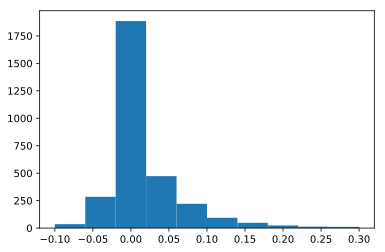

In [100]:
plt.hist(df_ld_delta[df_ld_delta['zone_id'].isin(treatment_zones)]['ld_delta'])

(array([ 25., 286., 790., 181.,  86.,  40.,  19.,   6.,   4.,   6.]),
 array([-0.087 , -0.0483, -0.0096,  0.0291,  0.0678,  0.1065,  0.1452,
         0.1839,  0.2226,  0.2613,  0.3   ]),
 <a list of 10 Patch objects>)

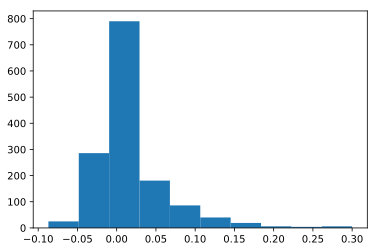

In [101]:
plt.hist(df_ld_delta[df_ld_delta['zone_id'].isin(control_zones)]['ld_delta'])

(array([93., 59., 96., 46., 46., 25., 16.,  6., 13.,  3.]),
 array([ 1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5, 26. ]),
 <a list of 10 Patch objects>)

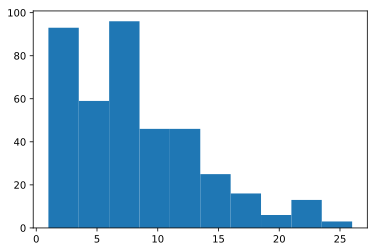

In [102]:
plt.hist(df[df['zone_id'].isin(treatment_zones)]['snow_days'])

(array([54., 24., 35., 34., 13., 21.,  6.,  8.,  3.,  3.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <a list of 10 Patch objects>)

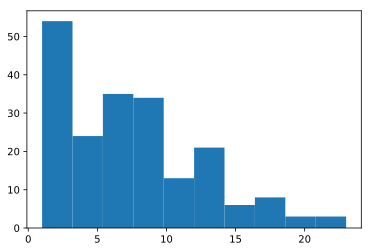

In [103]:
plt.hist(df[df['zone_id'].isin(control_zones)]['snow_days'])

(array([104.,  79.,  40.,  18.,  26.,   9.,  23.,  12.,  12.,   7.,   7.,
          9.,   9.,  12.,   6.,   4.,   4.,   2.,   2.,   2.,   0.,   3.,
          3.,   1.,   1.,   0.,   2.,   0.,   0.]),
 array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
         4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
         9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000,
        13500, 14000, 14500]),
 <a list of 29 Patch objects>)

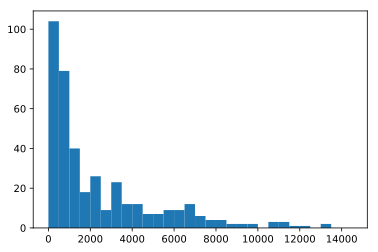

In [108]:
plt.hist(df[df['zone_id'].isin(treatment_zones)]['zone_del_r7d'],
        bins=[i * 500 for i in range(30)])

(array([52., 38., 19., 12.,  9.,  9.,  9.,  4.,  9.,  3.,  6.,  7.,  6.,
         2.,  3.,  0.,  1.,  2.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
         4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
         9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000,
        13500, 14000, 14500]),
 <a list of 29 Patch objects>)

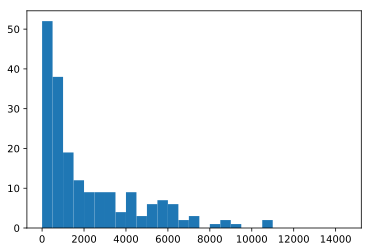

In [109]:
plt.hist(df[df['zone_id'].isin(control_zones)]['zone_del_r7d'],
        bins=[i * 500 for i in range(30)])